GO-BVO Predictive Model:

This study aims to analyze residential units that fall in the category of 20-70m high towers and see which factors have influence on the ratio of Bruttovloeroppervlakte(BVO) to Gebruiksoppervlakte(GO) in order to create a predictive model that estimates (GO) of an appartment given its outline. The outline of an appartment is a polygon whose area corresponds to the BVO. GO is of great importance in construction and real estate development since residences are priced based on their GO squared meters.

Preparing the dataset:

The dataset was manually constructed and consists of 5 residential projects with an average of 200 appartements per project. The process was mundane but necessary, at least for the early phases. Firstly the outline of each appartments was traced using AutoCAD. The idea here was to transform each appartment into a polygon. Then the polygons were exported to QGIS - a program that reads GeoData and transforms it into GeoJson files, which gives us the ability to treat each appartment as a a Json data row. QGIS also enables us to add variables to the Json files. I have manually added the following columns to the Json file and filled them for each appartment:

- layer - A code containing info about the floor and building where the appartment is located. (e.g. 15V-A means the appartment is located on the 15th floor in building A within a project)

- bvo - (Bruttovloeroppervlakte) Gross area of an appartment including the exterior walls, shafts and constructive elements. (Defined per NEN 2580 Dutch building code)

- go - (Gebruiksoppervlake) Usable area of an appartment excluding exterior walls, shafts and constructive elements. (Defined per NEN 2580 Dutch building code)

- app per floor - Number of appartments within the floor where said appartment is located.

- num floors - Number of floors within the building where said appartment exists.

- num angles - Number of angles with the appartment.

- corner unit - A binary value that tells whether the appartment is located at the corner of the floor or sandwiches between two appartments.

- right angle - A binary value that tells whether all angles in the appartment are right angles or not.

- winding order - A series of 0s and 1s that describe whether the angles within the appartment are convex (less than 180) or concave (greater than 180).



In [42]:
import numpy as np
import pandas as pd
import geopandas as gpd
# we suppres a warning regarding writing to a copy of dataframe. This is a false positive and annoying
pd.options.mode.chained_assignment = None  # default='warn'
import math
from shapely.geometry.polygon import orient
def angle(a, b, c):
    ang = math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0])
    ang = ang * -1
    return ang + np.pi*2 if ang < 0 else ang
def geometry_attribute_factory(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    # transform the multipolygons into polygons because the type is wrong
    polygons = [polygon.geoms[0] for polygon in gdf['geometry']]
    # add/set the target columns with default values
    gdf['complexity_score'] = 0.0
    gdf['concavity_clusters'] = 0.0
    gdf['angle_avg'] = 0.0
    gdf['angle_count'] = 0.0
    # start the iteration
    for idx, p in enumerate(polygons):
        # orient the handedness of the polygons so our angles match
        p = orient(p,sign=1.0)
        # extract the individual points from the polygon's exterior set
        points = np.array([(_p[0],_p[1]) for _p in p.exterior.coords])
        # construct lines from the individual points
        lines = np.c_[points[:-1],points[1:]].reshape(-1,2,2)
        # setup the default values
        angle_between = 0
        alignments = []
        concavity_clusters = 0
        # setup a state tracking boolean to make sure we cluster the boolean values
        concave = False
        # start iteration of the lines
        for i,line in enumerate(lines):
            # get the endpoint of the line
            point = line[1]
            # the angle needs to be calculated based on the previous line (index can be -1)
            line_from = lines[i-1]
            # if this value returns anything below 0 it means we have made a turn which will result into a concave and complex feature
            alignment = (line_from[1][0]-line_from[0][0])*(point[1]-line[0][1]) - (line_from[1][1]-line_from[0][1])*(point[0]-line[0][0])
            # simple addition with the goal of dividing the data by the angle count
            angle_between += angle(line_from[0],line_from[1],point)
            if alignment < 0:
                # if we have a negative alignment we need to check if we already counted this batch of concavity points
                if concave == False:
                    concavity_clusters += 1
                # we only need to add 1 for the first point in a streak
                concave = True
            else: concave = False
            # we could calculate this with another addition but I like to use numpy for these kinds of jobs.
            alignments.append(alignment < 0)
        # here we calculate the complexity by adding up all True (1) values
        complexity = np.sum(alignments)
        # we set the data on a per row basis.
        gdf['angle_count'][idx] = points.shape[0]-1
        gdf['angle_avg'][idx] = angle_between/(points.shape[0]-1)
        gdf['concavity_clusters'][idx] = concavity_clusters
        gdf['complexity_score'][idx] =complexity
    # return the new geodataframe
    return gdf
if __name__ == "__main__":
    gdf_pontkade  = gpd.read_file('./pontkade.geojson')
    gdf_pontkade_processed = geometry_attribute_factory(gdf_pontkade)
    input(gdf_pontkade_processed)

The preivous code snippet was developed by my colleague Joey Van Doesburg to help me automate the process of calculating the following features:

complexity_score - A value that describe how complex is the polygon. (More concave angles means higher complexity)

concavity_clusters - Number of concave clusters (reflex angles) within the appartment.

angle_avg - Average angle size within the appartment. (value in radian)

angle_count - Number of angles with the appartment.

These features aim to articulate the geometric differences between appartments in an aim to describe them in numbers for the algorithm.

In [43]:
gdf_pontkade_processed.head()

,fid,layer,bvo,go,app per floor,num floors,num angles,corner unit,right angle,winding order,geometry,complexity_score,concavity_clusters,angle_avg,angle_count
0,1,BG-A,43.61,36.13,7.0,9.0,4.0,0.0,1.0,1111,"MULTIPOLYGON Z (((99736.996 75852.734 0.000, 1...",0.0,0.0,1.570796,4.0
1,2,BG-A,42.24,36.13,7.0,9.0,4.0,0.0,1.0,1111,"MULTIPOLYGON Z (((96651.039 71421.383 0.000, 1...",0.0,0.0,1.570796,4.0
2,3,BG-A,42.23,36.13,7.0,9.0,4.0,0.0,1.0,1111,"MULTIPOLYGON Z (((93565.081 66990.033 0.000, 9...",0.0,0.0,1.570796,4.0
3,4,BG-A,42.23,36.13,7.0,9.0,4.0,0.0,1.0,1111,"MULTIPOLYGON Z (((90479.124 62558.682 0.000, 9...",0.0,0.0,1.570796,4.0
4,5,BG-A,42.23,36.13,7.0,9.0,4.0,0.0,1.0,1111,"MULTIPOLYGON Z (((87393.167 58127.332 0.000, 9...",0.0,0.0,1.570796,4.0


In [44]:
if __name__ == "__main__":
    gdf_pvp  = gpd.read_file('./pvpnew.geojson')
    gdf_pvp_processed = geometry_attribute_factory(gdf_pvp)
    input(gdf_pvp_processed)
gdf_pvp_processed= gdf_pvp_processed.astype({'num floors':'float'})
gdf_pvp_processed.head()

,fid,layer,bvo,go,app per floor,num floors,corner unit,right angle,geometry,complexity_score,concavity_clusters,angle_avg,angle_count
0,1,2V,957.24,NaN,NaN,20.0,NaN,NaN,"MULTIPOLYGON Z (((30340.957 -237679.742 0.000,...",1.0,1.0,2.094395,6.0
1,2,2V-A,93.10,81.54,9.0,20.0,1.0,0.0,"MULTIPOLYGON Z (((17913.438 -237680.119 0.000,...",4.0,3.0,2.617994,12.0
2,3,2V-A,86.57,74.65,9.0,20.0,1.0,1.0,"MULTIPOLYGON Z (((30340.957 -237680.236 0.000,...",2.0,2.0,2.356194,8.0
3,4,2V-A,72.82,62.92,9.0,20.0,0.0,1.0,"MULTIPOLYGON Z (((30340.957 -249604.736 0.000,...",1.0,1.0,2.094395,6.0
4,5,2V-A,101.32,87.54,9.0,20.0,0.0,1.0,"MULTIPOLYGON Z (((7002.249 -258762.235 0.000, ...",3.0,3.0,2.513274,10.0


In [45]:
if __name__ == "__main__":
    gdf_ndsm10  = gpd.read_file('./ndsm10.geojson')
    gdf_ndsm10_processed = geometry_attribute_factory(gdf_ndsm10)
    input(gdf_ndsm10_processed)

gdf_ndsm10_processed.head()

,fid,layer,bvo,go,app per floor,num floors,num angles,corner unit,right angle,winding order,geometry,complexity_score,concavity_clusters,angle_avg,angle_count
0,1,1V,1241.64,NaN,NaN,NaN,NaN,NaN,NaN,None,"MULTIPOLYGON Z (((110095.000 43065.000 0.000, ...",13.0,6.0,2.932153,30.0
1,2,1V,1648.68,NaN,NaN,NaN,NaN,NaN,NaN,None,"MULTIPOLYGON Z (((74765.000 62925.000 0.000, 9...",10.0,6.0,2.868411,23.0
2,3,1V-6,80.55,72.40,9.0,9.0,6.0,0.0,1.0,110111,"MULTIPOLYGON Z (((110095.000 43065.000 0.000, ...",1.0,1.0,2.094395,6.0
3,4,1V-6,76.81,68.75,9.0,9.0,6.0,0.0,1.0,110111,"MULTIPOLYGON Z (((90595.000 43065.000 0.000, 1...",1.0,1.0,2.094395,6.0
4,5,1V-6,77.31,70.43,9.0,9.0,4.0,0.0,1.0,1111,"MULTIPOLYGON Z (((110095.000 34680.000 0.000, ...",0.0,0.0,1.570796,4.0


In [46]:
if __name__ == "__main__":
    gdf_wsc  = gpd.read_file('./wsc.geojson')
    gdf_wsc_processed = geometry_attribute_factory(gdf_wsc)
    input(gdf_wsc_processed)
gdf_wsc_processed= gdf_wsc_processed.astype({'app per floor':'float','num floors':'float','corner unit':'float','right angle':'float'})
gdf_wsc_processed.head()

,fid,layer,bvo,go,app per floor,num floors,corner unit,right angle,geometry,complexity_score,concavity_clusters,angle_avg,angle_count
0,1,1V-A,91.01,76.49,10.0,18.0,1.0,0.0,"MULTIPOLYGON Z (((378403.539 2464.666 0.000, 3...",5.0,5.0,2.692794,14.0
1,2,1V-A,90.99,76.49,10.0,18.0,1.0,0.0,"MULTIPOLYGON Z (((410623.539 7721.995 0.000, 4...",5.0,5.0,2.692794,14.0
2,3,1V-A,77.35,69.07,10.0,18.0,0.0,1.0,"MULTIPOLYGON Z (((403423.539 7721.995 0.000, 4...",2.0,2.0,2.356194,8.0
3,4,1V-A,105.87,91.66,10.0,18.0,0.0,1.0,"MULTIPOLYGON Z (((393223.539 -1546.210 0.000, ...",2.0,2.0,2.356194,8.0
4,5,1V-A,77.36,68.95,10.0,18.0,0.0,1.0,"MULTIPOLYGON Z (((386023.353 -2626.210 0.000, ...",2.0,2.0,2.356194,8.0


In [47]:
gdf = pd.concat([gdf_ndsm10_processed, gdf_pontkade_processed,gdf_pvp_processed,gdf_wsc_processed], axis=0, join='outer')
gdf = gdf.reset_index(drop=True)
gdf = gdf.drop(['geometry','num angles','winding order'], axis = 1)
gdf['ratio'] = gdf['go']/gdf['bvo']
gdf = gdf.dropna()
print(gdf)

     fid  layer     bvo      go  app per floor  num floors  corner unit  \
2      3   1V-6   80.55   72.40            9.0         9.0          0.0   
3      4   1V-6   76.81   68.75            9.0         9.0          0.0   
4      5   1V-6   77.31   70.43            9.0         9.0          0.0   
5      6   1V-6   78.76   69.07            9.0         9.0          0.0   
6      7   1V-6   71.64   64.69            9.0         9.0          0.0   
..   ...    ...     ...     ...            ...         ...          ...   
869  174  16V-A   91.54   76.58            6.0        18.0          0.0   
870  184  17V-A  120.57  101.09            6.0        18.0          1.0   
871  186  17V-A  120.55  101.09            6.0        18.0          1.0   
873  180  17V-A   79.91   65.34            6.0        18.0          0.0   
874  185  17V-A   91.54   72.32            6.0        18.0          0.0   

     right angle  complexity_score  concavity_clusters  angle_avg  \
2            1.0              

Here we concatenate the datasets into one, drop the NaN values and calculate the ratio of BVO/GO. The ratio here is used to look for any correlations between it and the features in order to be later used in the training model.

In [48]:
if __name__ == "__main__":
    gdf_binnen  = gpd.read_file('./binnendok.geojson')
    gdf_binnen_processed = geometry_attribute_factory(gdf_binnen)
    input(gdf_binnen_processed)

gdf_binnen_processed.head()

,fid,layer,bvo,right angle,go,app per floor,num floors,num angles,corner unit,winding order,geometry,complexity_score,concavity_clusters,angle_avg,angle_count
0,249,10V,481.67,NaN,NaN,NaN,NaN,NaN,NaN,None,"MULTIPOLYGON Z (((54310.000 28988.000 0.000, 2...",0.0,0.0,1.570796,4.0
1,250,10V-B,84.65,1.0,70.10,5.0,19.0,8.0,1.0,11011011,"MULTIPOLYGON Z (((30477.500 23163.250 0.000, 2...",2.0,2.0,2.356194,8.0
2,251,10V-B,75.31,1.0,62.76,5.0,19.0,14.0,0.0,11101100110110,"MULTIPOLYGON Z (((43055.000 12737.000 0.000, 4...",5.0,4.0,2.692794,14.0
3,252,10V-B,84.57,1.0,70.10,5.0,19.0,8.0,1.0,11011011,"MULTIPOLYGON Z (((54310.000 23177.500 0.000, 5...",2.0,2.0,2.356194,8.0
4,253,10V-B,96.02,1.0,80.62,5.0,19.0,10.0,1.0,1100110111,"MULTIPOLYGON Z (((44547.500 21277.500 0.000, 4...",3.0,2.0,2.513274,10.0


This seperate data set will be used as a test set. I opted here for an independent dataset for testing instead of using the train-test split method because I wanted to test the model on a completely foreign dataset as I'm focusing here on features that are mathematical and universal in nature. The trade-off here is that the model accuracy will be indicative to its accuracy regarding this specific dataset rather than a combination of all the projects included, but since the aim is to use this tool on completely new projects, I find it to be a good approach. Also the aim on the long term is to include around 30 projects for the model, and keep expanding it with every new project.

In [49]:

gdf_binnen = gdf_binnen.drop('geometry',1)
gdf_binnen = gdf_binnen.dropna()
gdf_binnen['ratio'] = gdf_binnen['go']/gdf_binnen['bvo']
gdf_binnen.head()

C:\Users\lar\AppData\Local\Temp\ipykernel_19500\1411844974.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  gdf_binnen = gdf_binnen.drop('geometry',1)


,fid,layer,bvo,right angle,go,app per floor,num floors,num angles,corner unit,winding order,complexity_score,concavity_clusters,angle_avg,angle_count,ratio
1,250,10V-B,84.65,1.0,70.10,5.0,19.0,8.0,1.0,11011011,2.0,2.0,2.356194,8.0,0.828116
2,251,10V-B,75.31,1.0,62.76,5.0,19.0,14.0,0.0,11101100110110,5.0,4.0,2.692794,14.0,0.833355
3,252,10V-B,84.57,1.0,70.10,5.0,19.0,8.0,1.0,11011011,2.0,2.0,2.356194,8.0,0.828899
4,253,10V-B,96.02,1.0,80.62,5.0,19.0,10.0,1.0,1100110111,3.0,2.0,2.513274,10.0,0.839617
5,254,10V-B,81.21,1.0,68.54,5.0,19.0,8.0,1.0,11011011,2.0,2.0,2.356194,8.0,0.843985


,fid,bvo,go,app per floor,num floors,corner unit,right angle,complexity_score,concavity_clusters,angle_avg,angle_count,ratio
fid,1.000000,0.041282,0.024901,-0.488798,-0.024035,0.121549,0.055772,0.139556,0.080082,0.117470,0.145628,-0.127457
bvo,0.041282,1.000000,0.994500,-0.244642,0.116279,0.407883,-0.346500,0.618336,0.592062,0.540705,0.617684,-0.108709
go,0.024901,0.994500,1.000000,-0.218916,0.094531,0.354393,-0.323126,0.606694,0.571346,0.513386,0.604184,-0.006622
app per floor,-0.488798,-0.244642,-0.218916,1.000000,0.086064,-0.261170,0.027395,-0.326403,-0.214312,-0.266202,-0.331437,0.260332
num floors,-0.024035,0.116279,0.094531,0.086064,1.000000,0.341213,-0.345235,0.327950,0.407978,0.381380,0.333354,-0.194194
corner unit,0.121549,0.407883,0.354393,-0.261170,0.341213,1.000000,-0.546588,0.549340,0.653362,0.618101,0.561447,-0.547398
right angle,0.055772,-0.346500,-0.323126,0.027395,-0.345235,-0.546588,1.000000,-0.577586,-0.672007,-0.535783,-0.588620,0.267385
complexity_score,0.139556,0.618336,0.606694,-0.326403,0.327950,0.549340,-0.577586,1.000000,0.944635,0.815099,0.997780,-0.186798
concavity_clusters,0.080082,0.592062,0.571346,-0.214312,0.407978,0.653362,-0.672007,0.944635,1.000000,0.864730,0.947323,-0.260919
angle_avg,0.117470,0.540705,0.513386,-0.266202,0.381380,0.618101,-0.535783,0.815099,0.864730,1.000000,0.828349,-0.298559


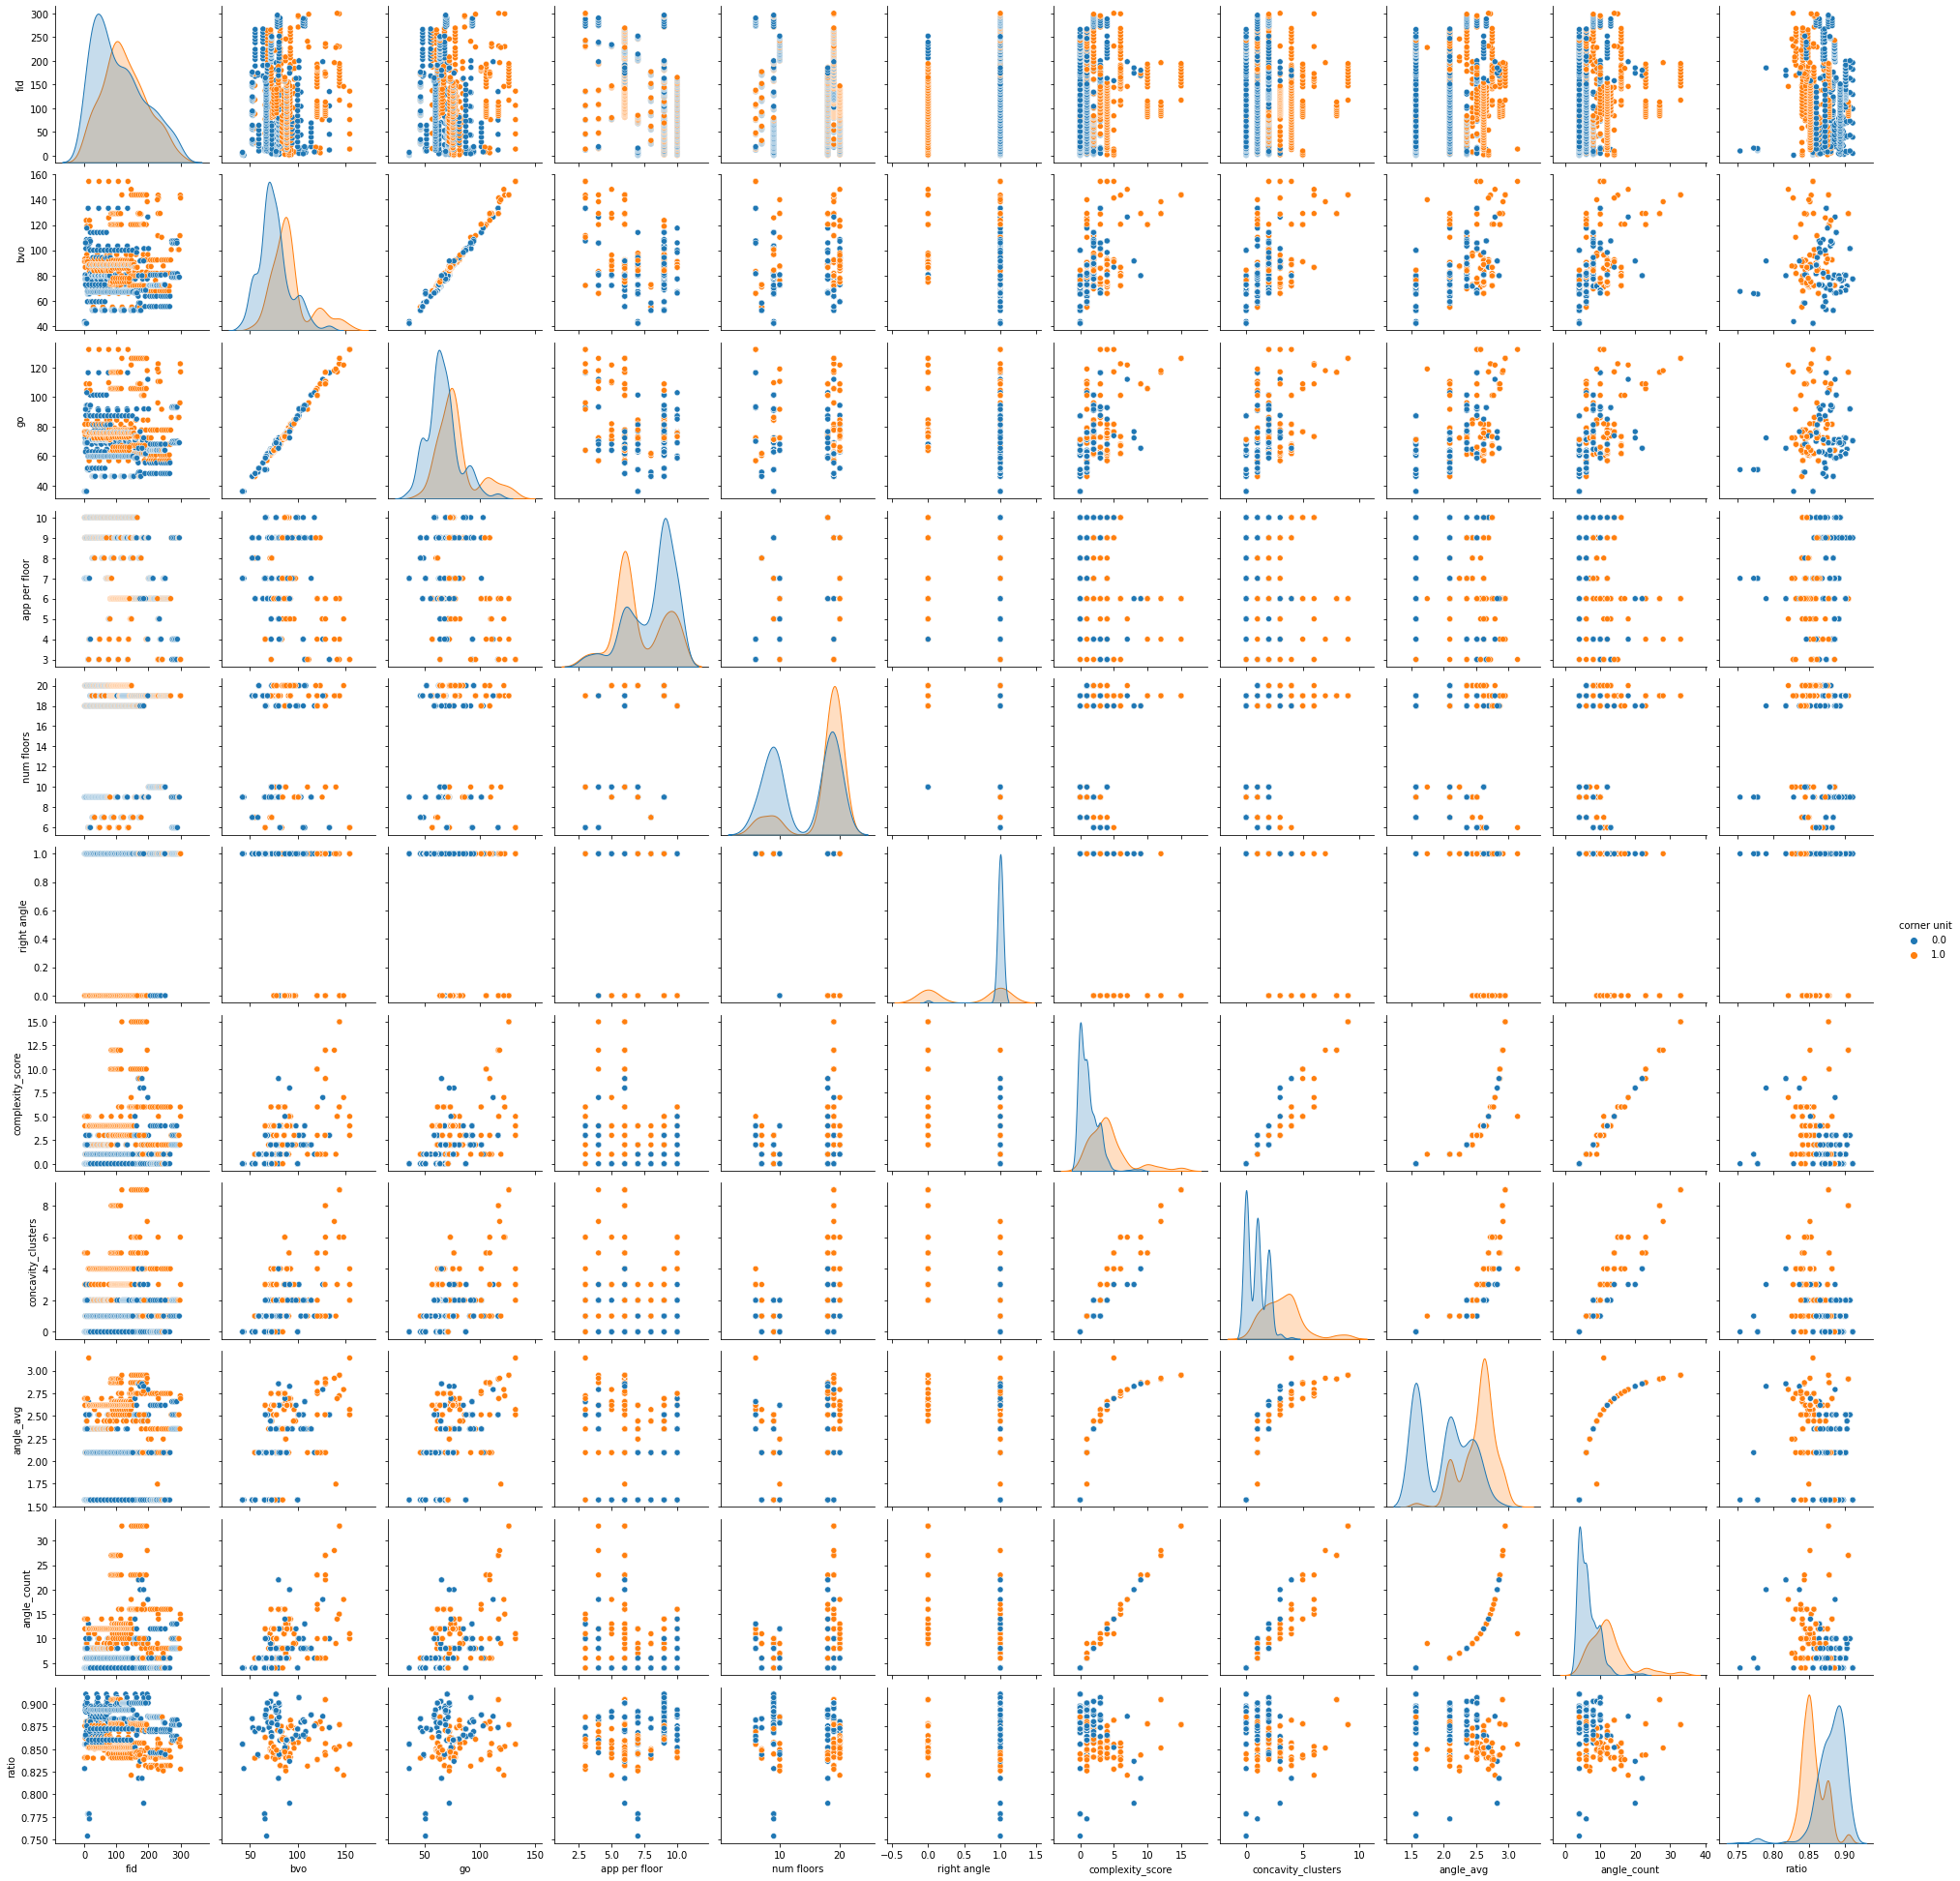

In [50]:
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
sns.pairplot(gdf, hue='corner unit')
gdf.corr()

Since the correlation is already very high between BVO and GO, I'm focusing here on the correlation of other features with the Ratio in order to fine tune the model. 

<AxesSubplot:xlabel='corner unit', ylabel='ratio'>

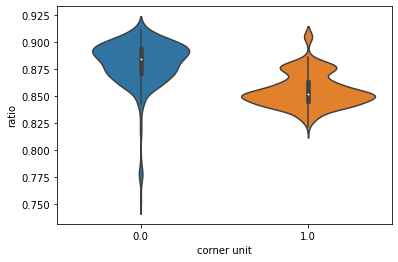

In [51]:
sns.violinplot(x='corner unit', y='ratio', data=gdf)

There is a strong correlation between whether an appartment is located in the corner of the building or not and its ratio. This is expected as such corner appartments have more exterior walls located at the elevation of the building, which are thicker than interior walls.

(0.8, 0.9)

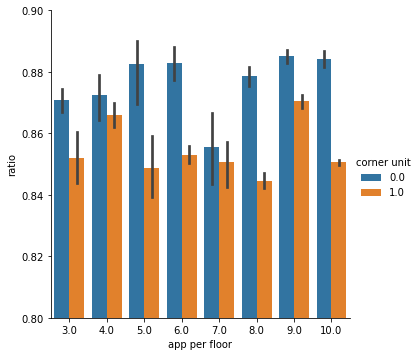

In [52]:
sns.catplot(
    data=gdf, kind="bar",
    x="app per floor", y="ratio", hue="corner unit")
plt.ylim(0.8, 0.9)

There seems to be a bit of correlation between number of appartments per floor and ratio. This might be due to the fact that the thicker exterior walls get divided on a higher number of appartments. This could be more true for "non-corner" appartments.

<AxesSubplot:xlabel='right angle', ylabel='ratio'>

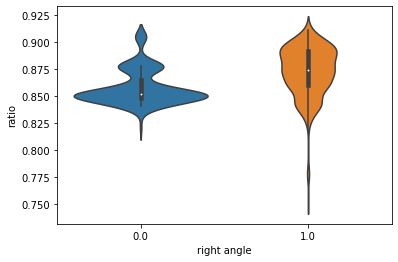

In [53]:
sns.violinplot(x='right angle', y='ratio', data=gdf)

Appartments with right angles seem to have a higher ratio, this could be explained though with the fact that appartments with non-right angles are usually corner units as such angles tend to be found on the exterior of the building rather than the interior.

c:\Users\lar\Anaconda3\envs\myenv\lib\site-packages\seaborn\categorical.py:3750: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


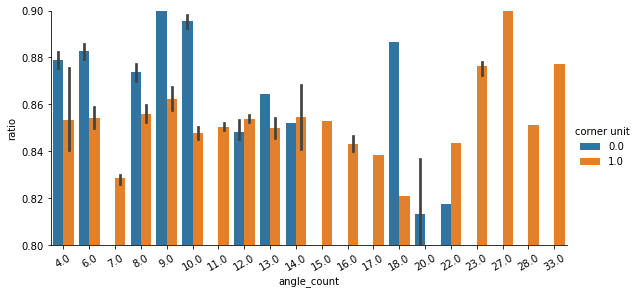

In [54]:
ax = sns.catplot(
    data=gdf, kind="bar",
    x="angle_count", y="ratio", hue="corner unit", size=4, aspect = 2)
plt.ylim(0.8, 0.9)
ax.set_xticklabels(rotation=30)
plt.show()

Here it seems that appartments with less complex shapes and and angles have a higher ratio. This is less true though for corner units, as more complexity could mean more interior walls which could increase the ratio.

(0.8, 0.9)

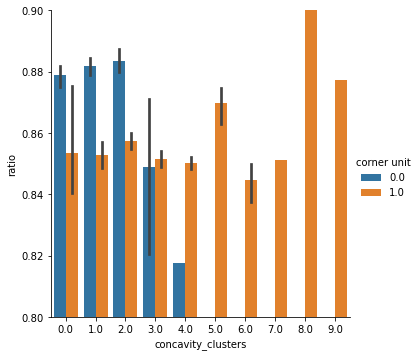

In [55]:
sns.catplot(
    data=gdf, kind="bar",
    x="concavity_clusters", y="ratio", hue="corner unit")
plt.ylim(0.8, 0.9)

(0.8, 0.9)

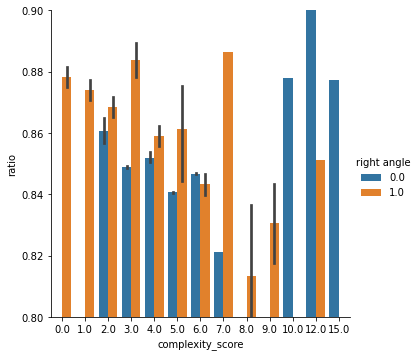

In [56]:
sns.catplot(
    data=gdf, kind="bar",
    x="complexity_score", y="ratio", hue="right angle")
plt.ylim(0.8, 0.9)

The last two graphs are quite similar since concavity clusters and complexity score are highly correlated. Both variables aim to describe the complexity of the shape. once these variables are plotted with the right angle and corner unit features, we notice a pattern where the highest ratios occur in simple, non-corner units and complex corner units. This could be a false observation nonetheless, as a bigger dataset is needed to verify such statment. 

(0.8, 0.9)

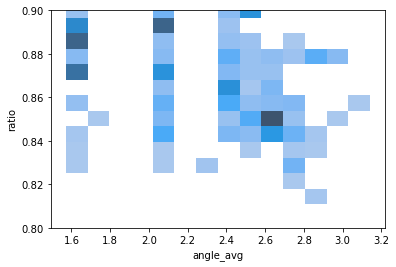

In [57]:
sns.histplot(
    data=gdf,
    x="angle_avg", y="ratio")
plt.ylim(0.8, 0.9)

This heatmap shows the relation between average angle size and ratio. There seems to be clusters of appartments with more right angles and higher ratios, and ones with non-right angles and lower ratios. 

(0.8, 0.9)

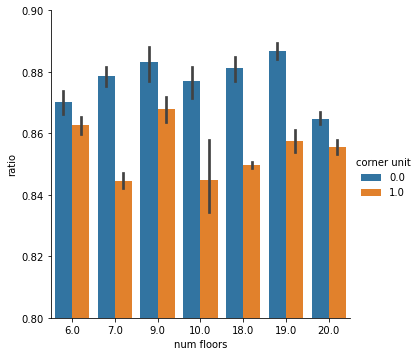

In [58]:
sns.catplot(
    data=gdf, kind="bar",
    x="num floors", y="ratio", hue="corner unit")
plt.ylim(0.8, 0.9)

There seems to be a low correlation between number of floors per building and ratio. 

(0.8, 0.9)

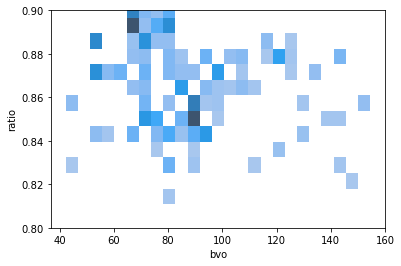

In [59]:
sns.histplot(
    data=gdf,
    x="bvo", y="ratio")
plt.ylim(0.8, 0.9)

The correlation between the ratio and BVO seems to be weak. Eventhough bigger appartments do result in a higher ratio due to the fact that there is simply more GO area, this correlation seems to be countered by the fact that bigger apparments are more likely to be corner units.

In [60]:
X_test = gdf_binnen_processed[['bvo','app per floor','corner unit','right angle','complexity_score','concavity_clusters','angle_avg','angle_count']]
y_test = gdf_binnen_processed['go']
#y_test=y_test.astype('int')
X_test = X_test.dropna()
y_test = y_test.dropna()
X_test.head()


,bvo,app per floor,corner unit,right angle,complexity_score,concavity_clusters,angle_avg,angle_count
1,84.65,5.0,1.0,1.0,2.0,2.0,2.356194,8.0
2,75.31,5.0,0.0,1.0,5.0,4.0,2.692794,14.0
3,84.57,5.0,1.0,1.0,2.0,2.0,2.356194,8.0
4,96.02,5.0,1.0,1.0,3.0,2.0,2.513274,10.0
5,81.21,5.0,1.0,1.0,2.0,2.0,2.356194,8.0


In [61]:


X = gdf[['bvo','app per floor','corner unit','right angle','complexity_score','concavity_clusters','angle_avg','angle_count']]
y = gdf['go']
#y=y.astype('int')
y.head()

2    72.40
3    68.75
4    70.43
5    69.07
6    64.69
Name: go, dtype: float64

Upon observing the correlation of different features with the ratio, I opted to include these features in the training of the model.

In [62]:
from sklearn.svm import SVR

svr = SVR(kernel='linear', C=20, epsilon=0.20).fit(X, y)
print(svr)

SVR(C=20, epsilon=0.2, kernel='linear')


Having tried and tested different algorithms for this model, including linear regression, random forest, KNN regression and support vector regression, I went with the latter as the predictive model is regressive in nature. Also due to a number of non-linear correlations withing the features of the dataset, SVR had an advantage of linear regression. After testing different alogithms, SVR did produce the highest level of accuracy. 

In [63]:
y_pred = svr.predict(X_test)

In [64]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math
mae_r = mean_absolute_error(y_test, y_pred)
mse_r = mean_squared_error(y_test, y_pred)
print(mae_r)
print(mse_r)
print(r2_score(y_test,y_pred))
print(math.sqrt(mean_squared_error(y_test, y_pred)))

1.3854104264748082
2.8011242621430887
0.9672628992287624
1.6736559569227747


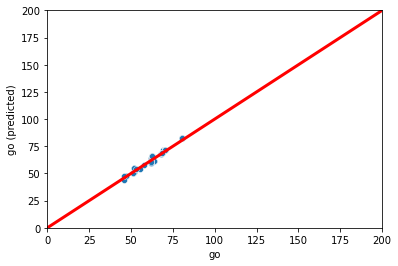

In [65]:
sns.scatterplot(x=y_test,y=y_pred)
plt.xlim(0, 200)
plt.ylim(0, 200)
plt.plot([0, 1.5e6], [0, 1.5e6], color='red', lw=3) 
plt.xlabel('go')
plt.ylabel('go (predicted)')
plt.show()

In [67]:
print(svr.intercept_)
print(svr.coef_)

[-1.95371027]
[[ 8.75953754e-01  2.86325505e-01 -1.94225530e+00  2.49342159e-01
   7.15617436e-01 -9.63620104e-01  6.81727829e-02 -4.49901530e-04]]


$GO = -1.95 + 0.8759 * BVO + 0.29 * app. per. floor - 1.94 * corner. unit + 0.25 * right. angle + 0.71 * complexity. score - 0.96 * no. concavity. clusters + 0.07 * angles. average - 0.0005 * angle. count$

Conclusion:

- R² is 0.9672. This reflects the accuracy of the model. Upon testing the model with using BVO alone as a feature, it return an R² score of (0.9269). While this is considered high in other models, in order for this model to be functional we need a very high level of accuracy, thus the new R² score is quite an improvement.

- RMSE is 1.67m². this error margin is quite low, but not accurate enough to be used professionally.

- The use of another high-accuracy algorithm like neural networks could have been an option, but I didn't want to sacrifice the explainability of the model, as it is essential for me to properly understand the correlations and factors within the model.

Next Steps

- I plan to expand the dataset by 25-30 buildings in order imporve the overall accuracy of the model and allow it to be used in the future.

- I'm hoping to expand the scope of the study to include other factors such as sustainability, building costs and timeframes. I could potentially take it up as a graduation project as it highly relates to my field of work.